# Análisis de la operación del centro de telefonía virtual CallMeMaybe

Link a carpeta con archivos: https://drive.google.com/drive/folders/1TIU3dXI9rbuLrM0NflvOmST9ljrE3fiu?usp=sharing

CallMeMaybe es una empresa que presta servicio de telefonía virtual. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. 

## Objetivo:
Proporcionar a los supervisores información sobre los operadores menos eficaces.

**Características de un operador ineficaz**
* Un gran número de llamadas entrantes pérdidas (internas y externas).
* Un largo tiempo de espera para las llamadas entrantes.
* Un número reducido de llamadas realizadas.

## Descripción de la información a analizar:

**La base de datos `telecom_dataset_us.csv` contiene las siguientes columnas:**

* `user_id`: ID de la cuenta de cliente
* `date`: fecha en la que se recuperaron las estadísticas
* `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
* `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
* `operator_id`: identificador del operador
* `is_missed_call`: si fue una llamada perdida
* `calls_count`: número de llamadas
* `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
* `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

**El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:**

* `user_id`: ID de usuario/a
* `tariff_plan`: tarifa actual de la clientela
* `date_start`: fecha de registro de la clientela

## Etapas del análisis

**Preprocesamiento de datos:**
* Estudiar valores faltantes
* Estudiar valores duplicados
* Comprobar la exactitud de los nombres de las columnas
* Renombrar las columnas
* Eliminar duplicados
* Convertir tipos
* Reemplazar valores faltantes
* Detectar valores atípicos: eliminarlos o corregirlos.

**EDA:**
* Comprobar la distribución y la duración de las llamadas.
* Comprobar las correlaciones entre las columnas.
* Definir operadores eficaces e ineficaces.
* Asignar una clasificación a cada operador basándose en un análisis similar:
* Número de llamadas entrantes perdidas
* Tiempo de espera para llamadas entrantes
* Número de llamadas salientes

**Comprobar hipótesis estadísticas:**
* Diferencia entre el tiempo de espera promedio para llamadas entrantes de operadores eficaces e ineficaces.
* Diferencia entre las proporciones de llamadas entrantes perdidas de operadores eficaces e ineficaces.
* Diferencia entre el número promedio de llamadas salientes de operadores eficaces e ineficaces.

## Conclusiones y recomendaciones

In [190]:
# Importar librerías

import pandas as pd
import numpy as np
import scipy.stats as st
import statistics 
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date
from datetime import datetime, timezone


In [191]:
# Importar base de datos

dataset_df = pd.read_csv('telecom_dataset_new.csv', parse_dates=['date'])
clients_df = pd.read_csv('telecom_clients.csv', parse_dates=['date_start'])

## Preprocesamiento de datos

**Revisión general**

In [192]:
dataset_df.head()


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [193]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  float64                  
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
dtypes: bool(1), datetime64[ns, UTC+03:00](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB


In [194]:
clients_df.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [195]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


**Estudiar valores faltantes y únicos**

In [196]:
def missings(df):
    #Obtener el dataset
    #Regresa el df que contiene el número de valores ausentes y valores únicos para cada columna.
    data = []
    for col in df.columns:
        missings = len(df[df[col].isnull()])
        values = len(df) - missings
        perc_missings = round(missings / len(df) * 100, 2)
        uniq = df[col].nunique()
        data.append([col, values, missings, perc_missings, uniq])
    df_missings = pd.DataFrame(data, columns = ['column', 'values', 'missings', 'perc_missings', 'uniq'])
    return df_missings

In [197]:
missings_df = missings(dataset_df)
missings_df

,column,values,missings,perc_missings,uniq
0,user_id,53902,0,0.00,307
1,date,53902,0,0.00,119
2,direction,53902,0,0.00,2
3,internal,53785,117,0.22,2
4,operator_id,45730,8172,15.16,1092
5,is_missed_call,53902,0,0.00,2
6,calls_count,53902,0,0.00,502
7,call_duration,53902,0,0.00,5373
8,total_call_duration,53902,0,0.00,6040


In [198]:
miss_df = missings(clients_df)
miss_df

,column,values,missings,perc_missings,uniq
0,user_id,732,0,0.0,732
1,tariff_plan,732,0,0.0,3
2,date_start,732,0,0.0,73


Se puede identificar que del df dataset las columnas con valores ausentes son: "internal" y "operator_id", evaluaremos cómo proceder.

Del dataframe "clients" no se encontraron valores ausentes.

In [199]:
# Revisar número de operadores por usuario
dataset_df.groupby('user_id').agg({
    'operator_id': 'nunique', 'calls_count':'count'}).reset_index().rename(
    columns={'operator_id':'operators', 'calls_count':'trials'}).sort_values(by='operators', ascending=False).head()

,user_id,operators,trials
264,168187,50,2580
175,167626,48,1311
161,167497,30,1405
271,168252,28,929
248,168062,27,1182


In [200]:
# Revisar proporción entre llamadas internas/externas por usuario
# Número de intentos de llamada por usuario
user_calls = dataset_df.groupby('user_id').agg({'calls_count': 'count'}).reset_index()

# Número de intentos de llamada interna/externa por usuario
calls_type = dataset_df.pivot_table(
    index='user_id', columns='internal', values='calls_count', aggfunc='count').reset_index().fillna(0)
calls_type.columns = ['user_id', 'external', 'internal']
calls_type = calls_type.merge(user_calls, on='user_id', how='left') 
calls_type.head()

,user_id,external,internal,calls_count
0,166377,535.0,36.0,571
1,166391,14.0,6.0,20
2,166392,106.0,1.0,107
3,166399,23.0,0.0,23
4,166405,1017.0,23.0,1042


De la columna "internal", el 0.2% de la información está vacía, se revisó la proporción entre las llamadas internal y external y se identificó que hay usuarios con más de 100 llamadas externas contra 1 llamada inerna. Por lo que se identifica un riesgo de cambiar los valores manualmente. La acción será eliminarlos.

Respecto a la columna "operator_id", el 15 % del total de las filas está vacío, se revisó  si cada usuario tiene un solo operador (y así completar los espacios vacíos), pero no es así. Por el momento se van a clasificar como otro operador y más adelante se va a evaluar nuevamente si es necesario modificarlo.

In [201]:
# Eliminal valores ausentes de internal calls
dataset = dataset_df.dropna()

In [202]:
# Completar operadores vacíos
dataset_df.loc[dataset_df['operator_id'].isnull(), 'operator_id'] = 1

**Estudiar valores duplicados**

In [203]:
duplic = dataset_df.duplicated().sum()
print('Number of duplicated rows: {}'.format(duplic))
print('% of duplicated rows: {:.2%}'.format(duplic / len(dataset)))

Number of duplicated rows: 4900
% of duplicated rows: 10.73%


In [204]:
clients_df.duplicated().sum()

0

Del dataframe "dataset" 10.73% de las filas están duplicadas, se procederá a eliminarlas.

No hay filas duplicadas en el dataframe "clients".

In [205]:
# Eliminar valores duplicados
dataset_df = dataset_df.drop_duplicates()


**Convertir tipos de datos**

In [206]:

# Convertir columna 'internal' a boolean y "date" a datetime64
dataset_df['internal'] = dataset_df['internal'].astype('bool')
dataset_df['date'] = pd.to_datetime(dataset['date'].dt.date)

dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 41491 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  bool          
 4   operator_id          49002 non-null  float64       
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.1+ MB


In [207]:
# Convertir "tariff_plan" a tipo "category"
clients_df['tariff_plan'] = clients_df['tariff_plan'].astype('category')

clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    category      
 2   date_start   732 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 12.4 KB


In [208]:
# agregar tiempo de espera
dataset_df['wait_duration'] = dataset_df['total_call_duration'] - dataset_df['call_duration']

**Agrupar los dataframes en uno solo**

In [209]:

telecom_df= dataset_df.merge(clients_df, on='user_id', how='left')

## EDA

In [210]:
telecom_df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_duration,tariff_plan,date_start
0,166377,NaT,in,False,1.0,True,2,0,4,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25,B,2019-08-01


### Comprobar la distribución y la duración de las llamadas.

In [211]:
# Verificar que 'date_start' esté antes que 'date'
print('Número de filas con registro inválido de fecha: {}'.format(len(telecom_df.query('date < date_start'))))

Número de filas con registro inválido de fecha: 0


In [212]:
telecom_df[['date', 'date_start']].describe()

,date,date_start
count,41491,49002
mean,2019-10-23 15:58:20.739919616,2019-09-09 00:24:35.792824576
min,2019-08-02 00:00:00,2019-08-01 00:00:00
25%,2019-10-06 00:00:00,2019-08-19 00:00:00
50%,2019-10-28 00:00:00,2019-09-04 00:00:00
75%,2019-11-14 00:00:00,2019-10-01 00:00:00
max,2019-11-28 00:00:00,2019-10-31 00:00:00


* Los usuarios se registraron entre agosto y octubre de 2019.
* Los datos se recopilaron entre agosto y noviembre de 2019.

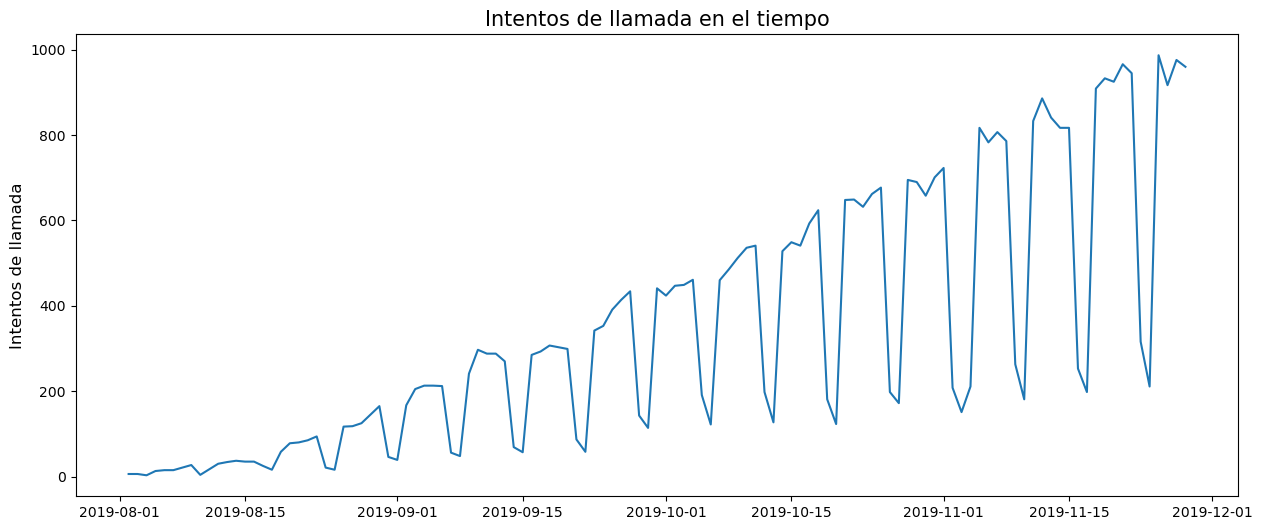

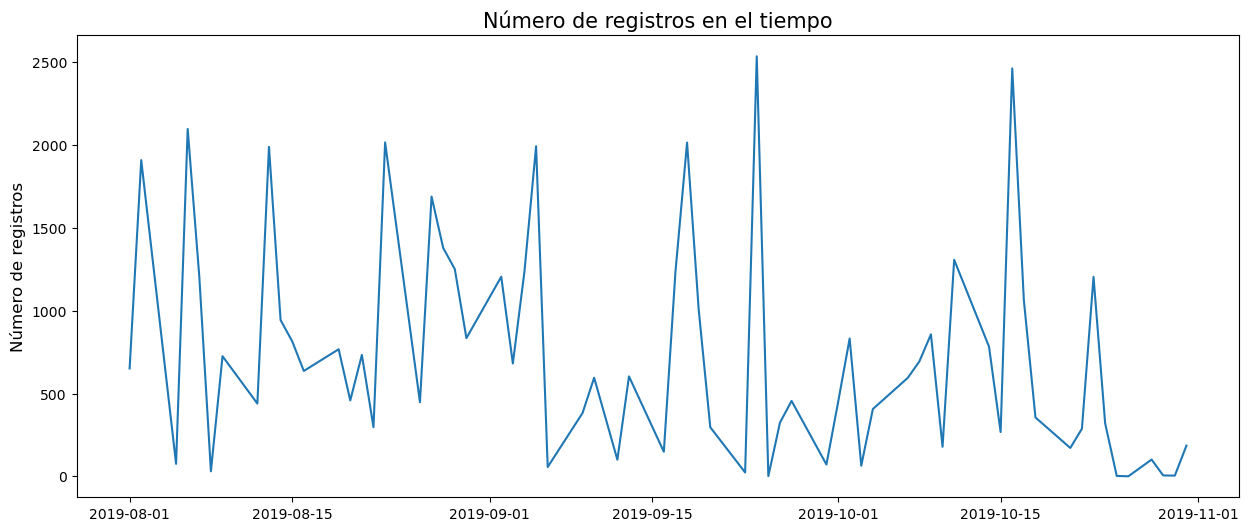

In [213]:
# Gráfico para mostrar los intentos de llamada en el tiempo
attemps_time = telecom_df.groupby('date').agg({
    'calls_count': 'count'}).reset_index().rename(
    columns={'calls_count': 'attemps_to_call'})

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(attemps_time.date, attemps_time.attemps_to_call)
plt.title('Intentos de llamada en el tiempo', fontsize=15)
plt.ylabel('Intentos de llamada', fontsize=12)
plt.show()

# Gráfico para mostrar registros en el tiempo
reg_time = telecom_df.groupby('date_start').agg({'user_id': 'count'}).reset_index().rename(columns={'user_id': 'reg'})

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(reg_time.date_start, reg_time.reg)
plt.title('Número de registros en el tiempo', fontsize=15)
plt.ylabel('Número de registros', fontsize=12)
plt.show()

Hay más intentos de realizar llamadas conforme pasa el tiempo

**Revisar distribución de llamadas ("direction", "internal", "missed calls" y "tariff plan")**

In [214]:
#Obtener los valores categóricos del df
# Mostrar la distribución de las categorías

def category_distribution(df):
    df['amount'] = 1
    for col in df.drop('amount', axis=1).columns:
        grouped = df.groupby(col).agg({'amount': 'count'}).reset_index()
        sns.barplot(x=col, y='amount', data=grouped, palette='Set2')
        plt.title('{} distribution'.format(col), fontsize='15')
        plt.show()

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_3494/1843902891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amount'] = 1
/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_3494/1843902891.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='amount', data=grouped, palette='Set2')


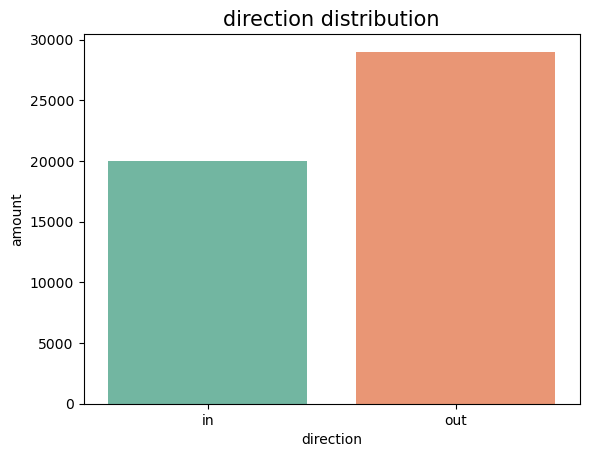

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_3494/1843902891.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='amount', data=grouped, palette='Set2')


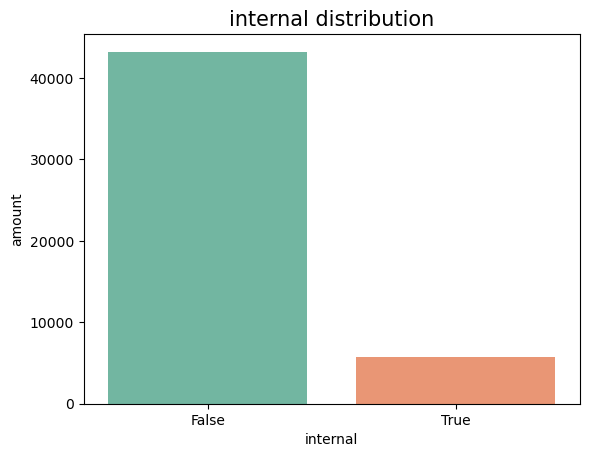

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_3494/1843902891.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='amount', data=grouped, palette='Set2')


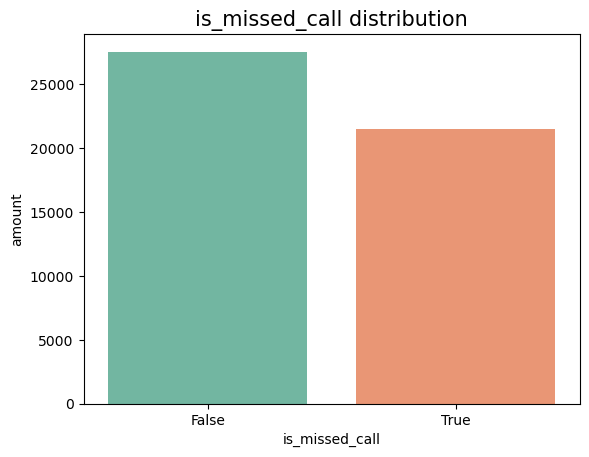

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_3494/1843902891.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(col).agg({'amount': 'count'}).reset_index()
/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_3494/1843902891.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='amount', data=grouped, palette='Set2')


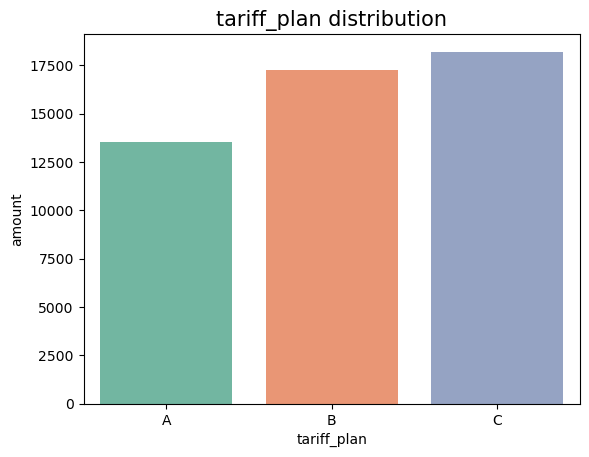

In [215]:
category_distribution(telecom_df[['direction', 'internal', 'is_missed_call', 'tariff_plan']])

* La mayoría de los intentos de llamada fueron realizados de los operadores a los clientes ('external')

**Número de llamadas, duración de llamada y duración total de llamadas.**

* Verificar la distribución de calls_count, call_duration y total_call_duration, dividiéndola en dos grupos: llamadas perdidas y contestadas.
* Cuando se pierde una llamada, su duración se supone que es 0.
* Cuando se contesta una llamada, su duración se supone que es mayor que 0.



In [216]:

telecom_df[['calls_count']].describe()

,calls_count
count,49002.000000
mean,16.462777
std,63.604098
min,1.000000
25%,1.000000
50%,4.000000
75%,12.000000
max,4817.000000


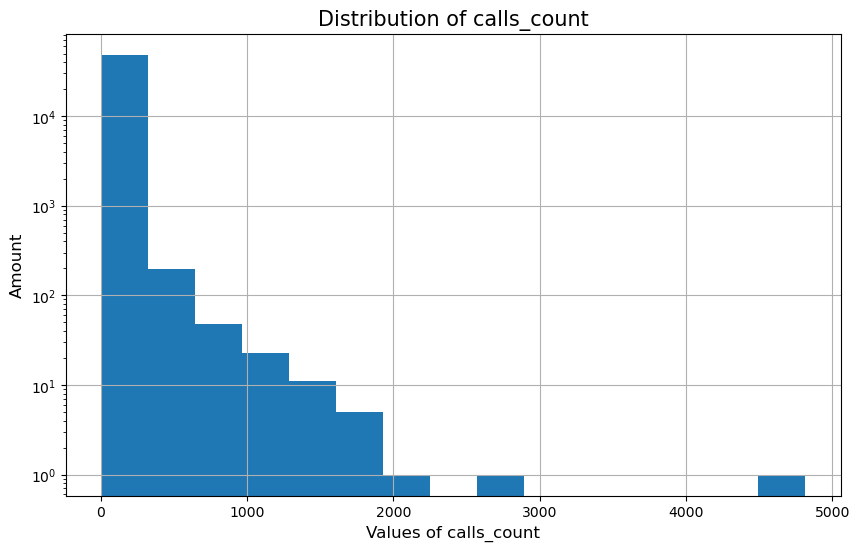

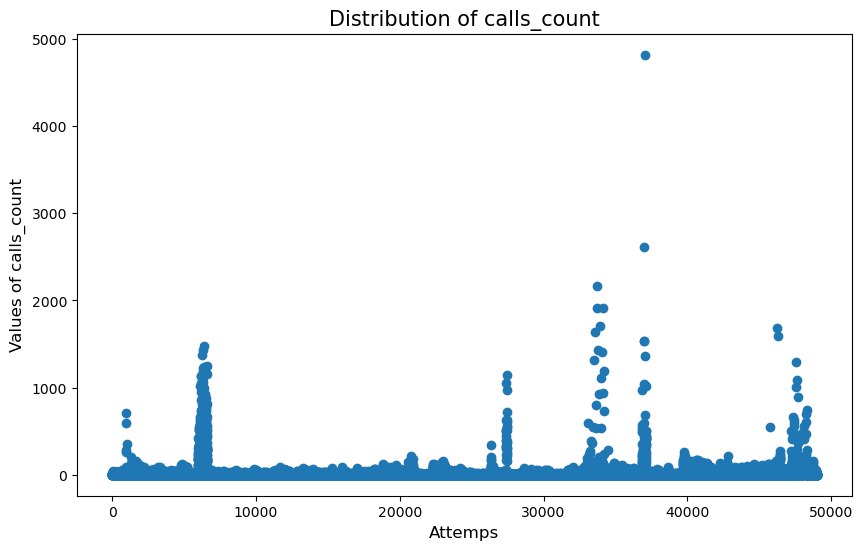

Lista de valores atípicos para calls_count - 90%, 92%, 95%, 97% ,99%
[ 35.  43.  62.  84. 165.]


In [217]:

def plot_distribution(df):
    # Tomar valores numéricos del df
    # Histogramas y scatters para cada columna
    # Valores atípicos: 90%, 92%, 95%, 97%, 99%
    for col in df.columns:
        # Plots histogram
        fig, ax = plt.subplots(figsize=(10, 6))
        df[col].hist(log=True, bins=15)
        plt.title('Distribution of {}'.format(col), fontsize=15)
        plt.xlabel('Values of {}'.format(col), fontsize=12)
        plt.ylabel('Amount', fontsize=12)
        plt.show()
        # Plots scatter plot
        fig, ax = plt.subplots(figsize=(10, 6))
        x_values = pd.Series(range(0, len(df[col])))
        plt.scatter(x_values, df[col])
        plt.title('Distribution of {}'.format(col), fontsize=15)
        plt.xlabel('Attemps', fontsize=12)
        plt.ylabel('Values of {}'.format(col), fontsize=12)
        plt.show()
        # Prints outliers by percentiles
        print('Lista de valores atípicos para {} - 90%, 92%, 95%, 97% ,99%'.format(col))
        print(np.percentile(df[col], [90, 92, 95, 97, 99]))

plot_distribution(telecom_df[['calls_count']])

Valores atípicos:

Tratar de hacer una llamada 35 veces al día (percentil 90%) es extraño. Significa que el 10% de los datos son atípicos, pero elegiremos trabajar con menos datos y de buena calidad en lugar de mostrar resultados ficticios.
La diferencia entre la media y la mediana también es una mala señal.
Por ahora, se marcaráesto como intentos de llamada.


In [218]:

# Marcar intentos de llamada como valores atípicos
PERC_LIMIT =  90
calls_count_limit = round(np.percentile(telecom_df.calls_count, PERC_LIMIT))
telecom_df['calls_count_outliers'] = telecom_df.calls_count >= calls_count_limit
# Mostrar diferencia en distribución
telecom_df.query('calls_count < @calls_count_limit')[['calls_count']].describe()

,calls_count
count,44022.000000
mean,6.312934
std,7.360403
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,34.000000


**Call_duration, total_call_duration & wait_duration**

* Realizar diferentes comprobaciones para llamadas pérdidas y contestadas.
* Verificar que la duración de la llamada no sea mayor que la duración total de la llamada.
* Para llamadas contestadas, la duración de la llamada es mayor que 0.
* Para llamadas perdidas, la duración de la llamada es 0.

In [219]:
# Verificar que la duración de la llamada no sea mayor que la duración total de la llamada
len(telecom_df.query('call_duration > total_call_duration'))

0

In [220]:
# Llamadas contestadas
call_ans = telecom_df.query('is_missed_call == False')
call_ans[['call_duration', 'total_call_duration', 'wait_duration']].describe()

,call_duration,total_call_duration,wait_duration
count,27549.000000,27549.000000,27549.000000
mean,1540.012124,1782.404116,242.391992
std,4931.324773,5738.099812,920.794502
min,0.000000,0.000000,0.000000
25%,109.000000,137.000000,19.000000
50%,444.000000,513.000000,53.000000
75%,1421.000000,1646.000000,177.000000
max,144395.000000,166155.000000,46474.000000


In [221]:
print('Número de llamadas contestadas de 0 a 3 segundos de duración: ', len(call_ans.query('call_duration <= 3')))

Número de llamadas contestadas de 0 a 3 segundos de duración:  241


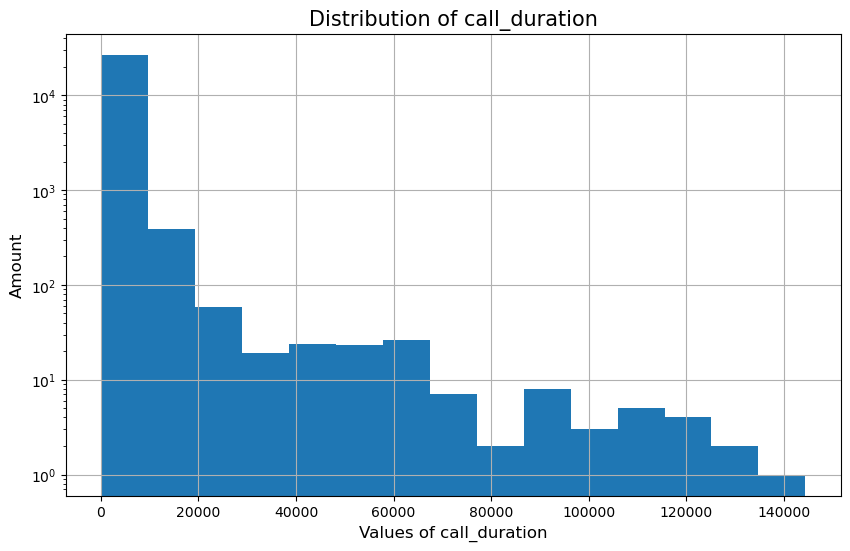

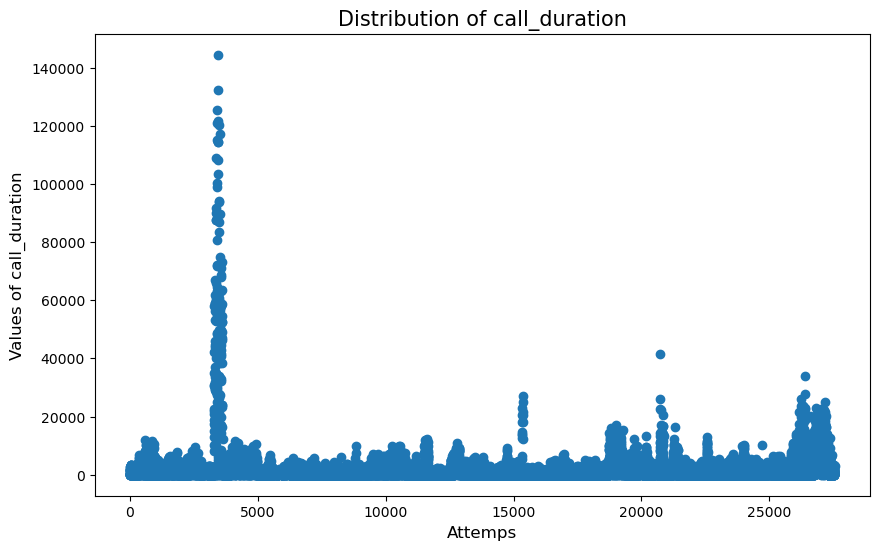

Lista de valores atípicos para call_duration - 90%, 92%, 95%, 97% ,99%
[ 3381.    4034.32  5626.8   7808.8  13966.28]


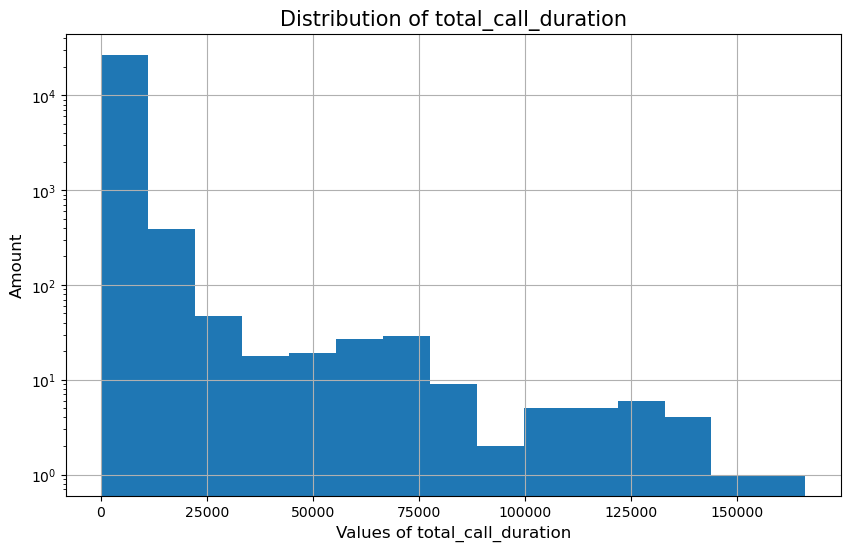

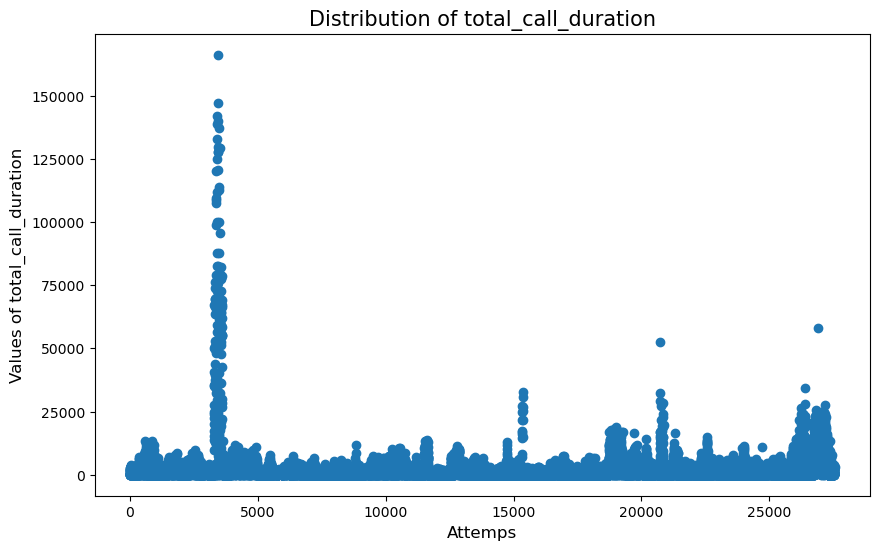

Lista de valores atípicos para total_call_duration - 90%, 92%, 95%, 97% ,99%
[ 3904.4   4604.28  6411.    8890.12 16109.24]


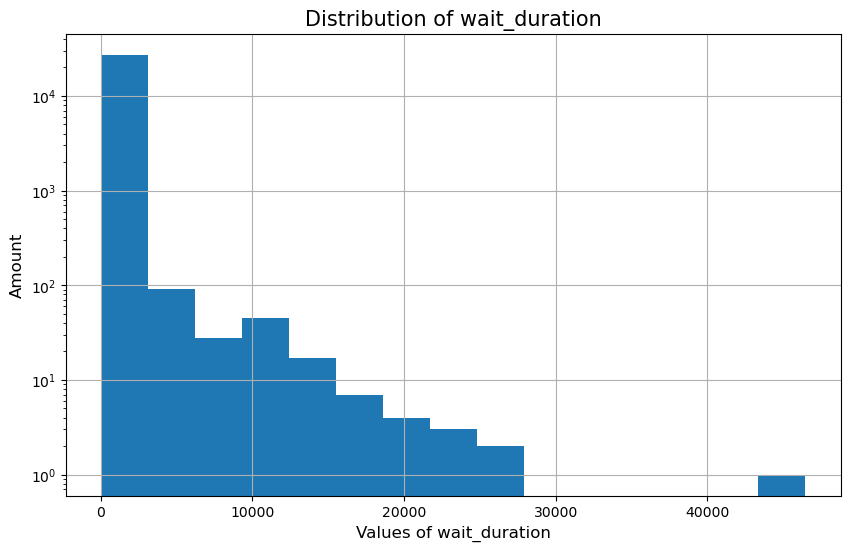

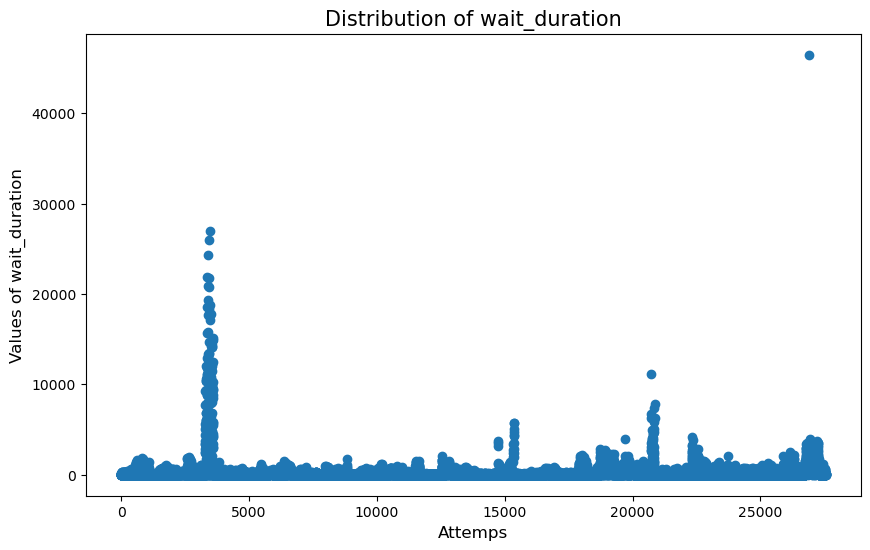

Lista de valores atípicos para wait_duration - 90%, 92%, 95%, 97% ,99%
[ 509.    631.    957.   1365.   2453.04]


In [222]:
plot_distribution(call_ans[['call_duration', 'total_call_duration', 'wait_duration']])

**Valores atípicos**

* call_duration:
    * Llamadas demasiado cortas (entre 0 y 3 segundos): probablemente se trate de un problema técnico o de una llamada que se desconectó inmediatamente. Este tipo de llamadas se produjo menos de 300 veces.
    * Llamadas demasiado largas: más de 1.5 horas (aproximadamente el 8 % del total de datos).
* total_call_duration*: llamadas demasiado largas: más de 2.5 horas (aproximadamente el 3 % del total de datos).
* wait_call_duration: espera demasiado larga: más de 45 minutos (aproximadamente el 1 % del total de datos).

Se evaluará la información posterior y se definirá si se hace algún cambio.

In [223]:
# Marcar valores atípicos
short_duration = 3
long_duration = np.percentile(call_ans['call_duration'], 92)
telecom_df['call_duration_outliers'] = (telecom_df['is_missed_call'] == False) & ((
    telecom_df.call_duration <= short_duration) | (
    telecom_df.call_duration >= long_duration))

long_total_duration = np.percentile(call_ans['total_call_duration'], 97)
telecom_df['total_call_duration_outliers'] = (telecom_df['is_missed_call'] == False) & (
    telecom_df.call_duration >= long_total_duration)

long_wait_duration = np.percentile(call_ans['wait_duration'], 99)
telecom_df['wait_duration_outliers'] = (telecom_df['is_missed_call'] == False) & (
    telecom_df.call_duration >= long_wait_duration)

In [224]:
telecom_df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_duration,tariff_plan,date_start,calls_count_outliers,call_duration_outliers,total_call_duration_outliers,wait_duration_outliers
0,166377,NaT,in,False,1.0,True,2,0,4,4,B,2019-08-01,False,False,False,False
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5,B,2019-08-01,False,False,False,False
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1,B,2019-08-01,False,False,False,False
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8,B,2019-08-01,False,False,False,False
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25,B,2019-08-01,False,False,False,False


**Para llamadas pérdidas**

In [225]:
call_miss = telecom_df.query('is_missed_call == True')
call_miss[['call_duration', 'total_call_duration', 'wait_duration']].describe()

,call_duration,total_call_duration,wait_duration
count,21453.000000,21453.000000,21453.000000
mean,1.107584,352.874377,351.766793
std,17.882223,1353.483608,1353.634877
min,0.000000,0.000000,0.000000
25%,0.000000,14.000000,13.000000
50%,0.000000,60.000000,58.000000
75%,0.000000,240.000000,238.000000
max,741.000000,45312.000000,45312.000000


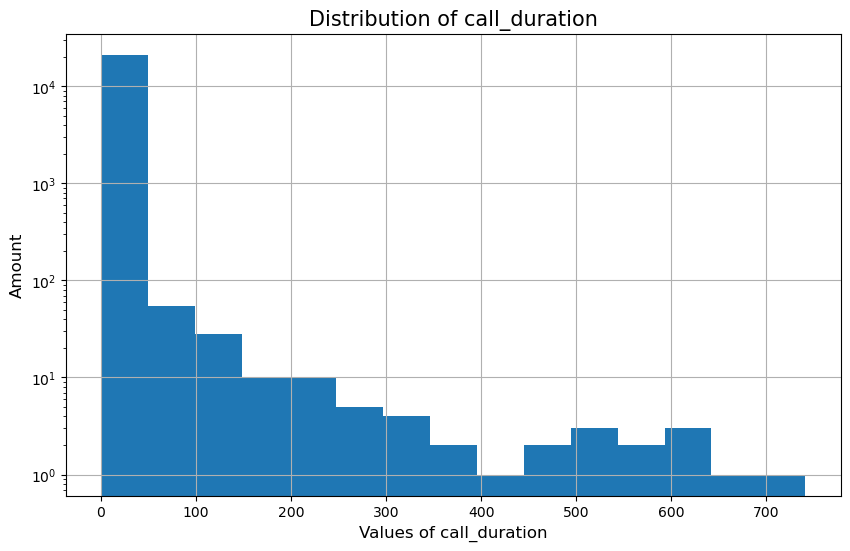

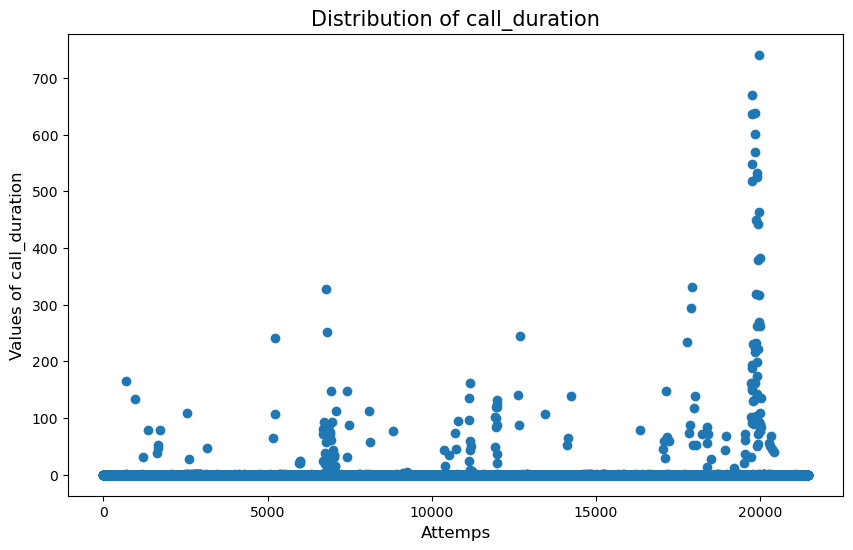

Lista de valores atípicos para call_duration - 90%, 92%, 95%, 97% ,99%
[0. 0. 0. 0. 1.]


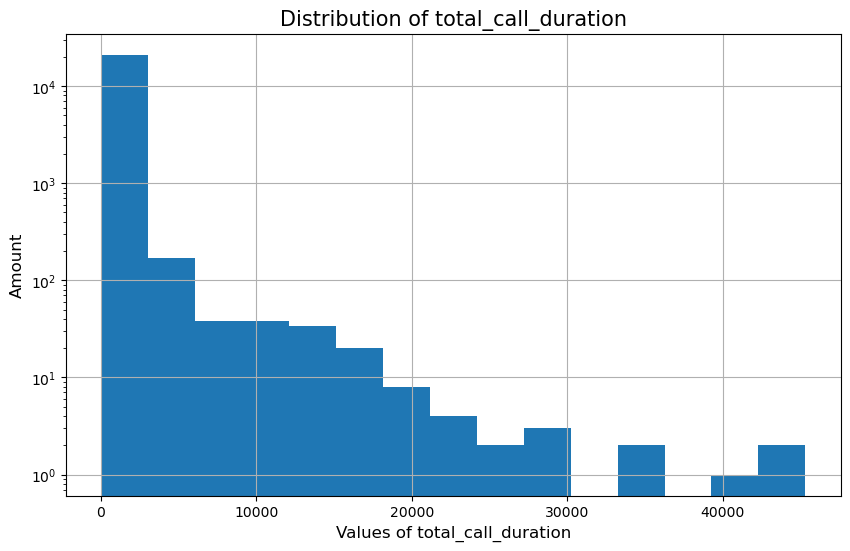

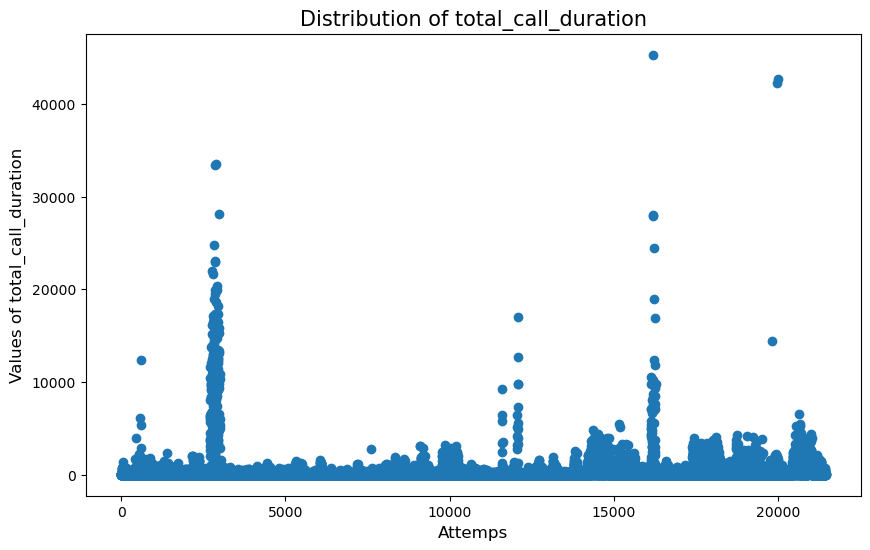

Lista de valores atípicos para total_call_duration - 90%, 92%, 95%, 97% ,99%
[ 769.    960.   1421.4  1974.32 4025.84]


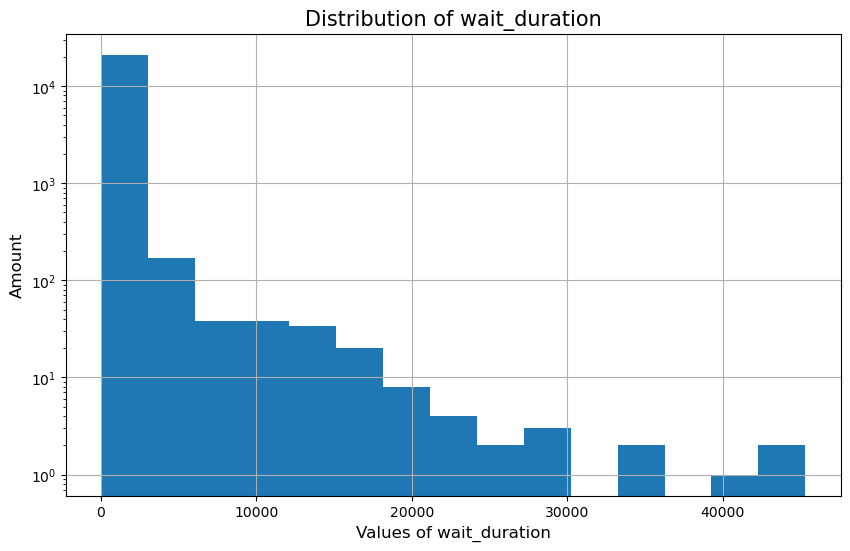

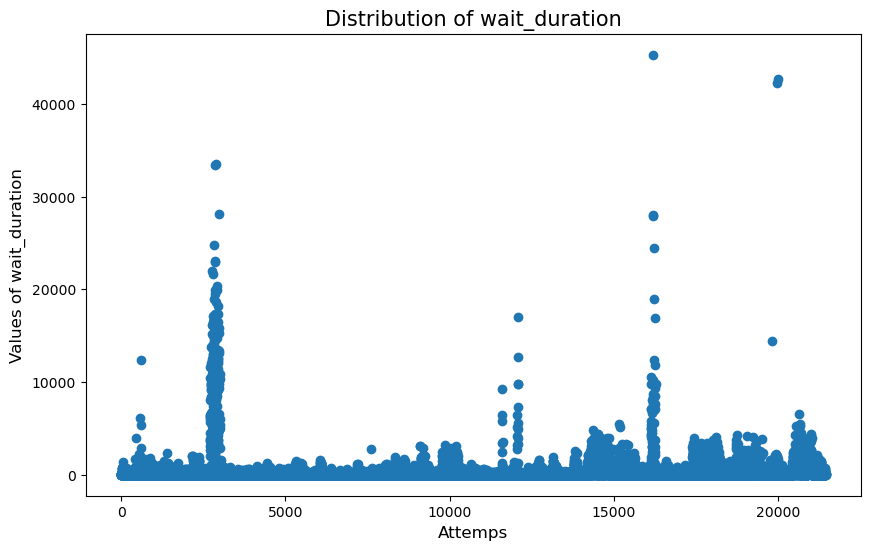

Lista de valores atípicos para wait_duration - 90%, 92%, 95%, 97% ,99%
[ 769.    960.   1421.4  1974.32 4025.84]


In [226]:
plot_distribution(call_miss[['call_duration', 'total_call_duration', 'wait_duration']])

In [227]:
len(call_miss.query('call_duration > 0'))

296

Valores atípicos:

* call_duration: Se supone que el tiempo debería ser 0, pero hay 295 llamadas con un tiempo mayor, así que se reclasificarán.
total_call_duration y wait_duration: llamadas demasiado largas (más de 1,5 horas, aproximadamente el 1 % del total de datos), así que se marcarán.

In [228]:
# Reclasificar call_duration, total_call_duration y wait_duration para llamadas perdidas 
telecom_df.loc[telecom_df['is_missed_call'] == True, 'total_call_duration'] = telecom_df.total_call_duration -telecom_df.call_duration
telecom_df.loc[telecom_df['is_missed_call'] == True, 'call_duration'] = 0
telecom_df['wait_duration'] = telecom_df.total_call_duration - telecom_df.call_duration

In [229]:
# Marcar los valores atípicos de wait_duration
long_total_duration = np.percentile(call_miss['total_call_duration'], 99)
telecom_df.loc[telecom_df['is_missed_call'] == True, 'total_call_duration_outliers'] = telecom_df.call_duration >= long_total_duration

long_wait_duration = np.percentile(call_miss['wait_duration'], 99)
telecom_df.loc[telecom_df['is_missed_call'] == True, 'wait_duration_outliers'] = telecom_df.call_duration >= long_wait_duration

In [230]:

outliers = telecom_df.query('calls_count_outliers == True or call_duration_outliers == True or total_call_duration_outliers == True or wait_duration_outliers == True')
print('Número de valores atípicos: ', len(outliers))
print('% de valores atípicos: {:.2%}'.format(len(outliers) / len(telecom_df)))

Número de valores atípicos:  7050
% de valores atípicos: 14.39%


**Eliminar valores atípicos**

La información está bastante desordenada, por lo que se va a eliminar ese 14.5% y trabajará con el resto de información más confiable.

In [231]:
telecom_df = telecom_df.query('calls_count_outliers == False and call_duration_outliers == False and total_call_duration_outliers == False and wait_duration_outliers == False')
telecom_df = telecom_df.drop(['calls_count_outliers', 'call_duration_outliers', 'total_call_duration_outliers', 'wait_duration_outliers'], axis=1)

In [232]:

telecom_df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_duration,tariff_plan,date_start
0,166377,NaT,in,False,1.0,True,2,0,4,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25,B,2019-08-01


* Mostrar distribución sin valores atípicos

In [233]:
# Llamadas respondidas
calls_ans = telecom_df.query('is_missed_call == False')
calls_ans[['calls_count', 'call_duration', 'total_call_duration', 'wait_duration']].describe()

,calls_count,call_duration,total_call_duration,wait_duration
count,22723.000000,22723.000000,22723.000000,22723.00000
mean,5.851208,534.124587,616.696607,82.57202
std,6.610866,586.699936,661.577259,112.32868
min,1.000000,4.000000,4.000000,0.00000
25%,1.000000,86.000000,112.000000,16.00000
50%,3.000000,295.000000,347.000000,39.00000
75%,8.000000,799.000000,922.000000,100.00000
max,34.000000,2452.000000,3834.000000,1463.00000


In [234]:
# Missing calls
calls_miss = telecom_df.query('is_missed_call == True')
calls_miss[['calls_count', 'call_duration', 'total_call_duration', 'wait_duration']].describe()

,calls_count,call_duration,total_call_duration,wait_duration
count,19229.000000,19229.0,19229.000000,19229.000000
mean,5.734360,0.0,120.872952,120.872952
std,7.031295,0.0,181.314555,181.314555
min,1.000000,0.0,0.000000,0.000000
25%,1.000000,0.0,11.000000,11.000000
50%,3.000000,0.0,44.000000,44.000000
75%,7.000000,0.0,150.000000,150.000000
max,34.000000,0.0,2187.000000,2187.000000


**Operator_id**

* Describir la distribución de recepción y realización de llamadas y verificar si todos realizaban ambas tareas.
* Confirmar la distribución de intentos de llamada y determinar cuantas llamadas realizan

In [235]:
# Distribución de operadores por tipo de trabajo
oper_dir = telecom_df.pivot_table(index='operator_id', columns='direction', values='calls_count', aggfunc='count'
                           ).reset_index().fillna(0)
oper_dir.columns = ['operator_id','in_calls', 'out_calls']
oper_dir['total_calls'] =  oper_dir.in_calls + oper_dir.out_calls
oper_dir.sort_values(by='total_calls')

,operator_id,in_calls,out_calls,total_calls
1082,973286.0,1.0,0.0,1.0
711,937872.0,0.0,1.0,1.0
696,937778.0,0.0,1.0,1.0
694,937772.0,0.0,1.0,1.0
693,937770.0,0.0,1.0,1.0
...,...,...,...,...
49,889410.0,79.0,163.0,242.0
191,900892.0,84.0,159.0,243.0
34,887276.0,67.0,196.0,263.0
204,901884.0,88.0,193.0,281.0


* Distribución de llamadas sin operadores en ceros, para quienes reciben llamadas 

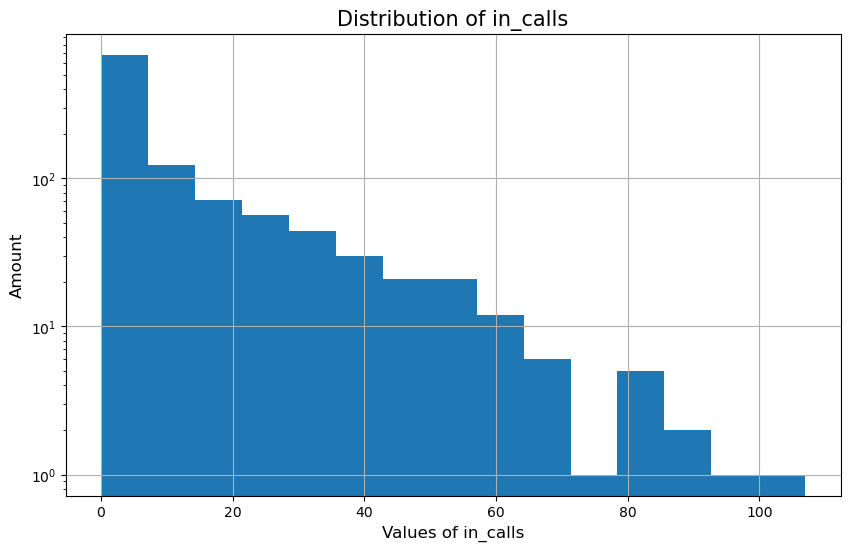

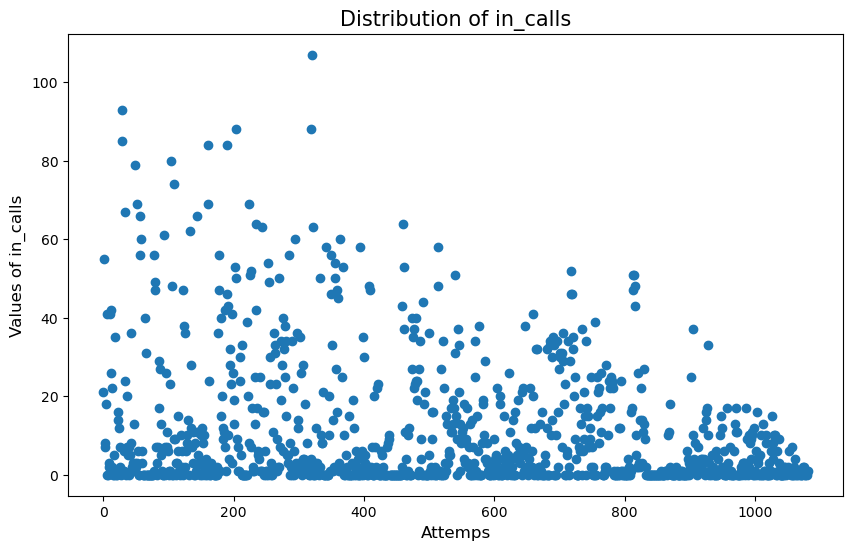

Lista de valores atípicos para in_calls - 90%, 92%, 95%, 97% ,99%
[34.   38.   47.95 55.57 69.  ]


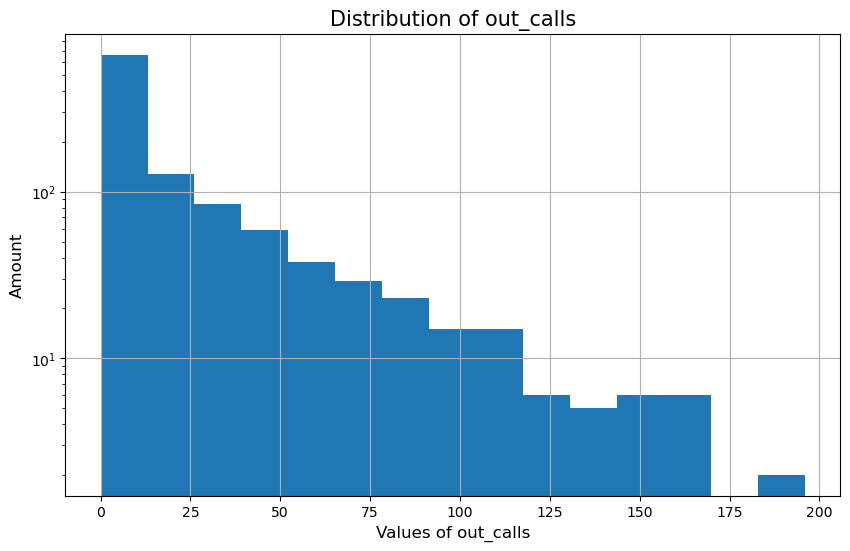

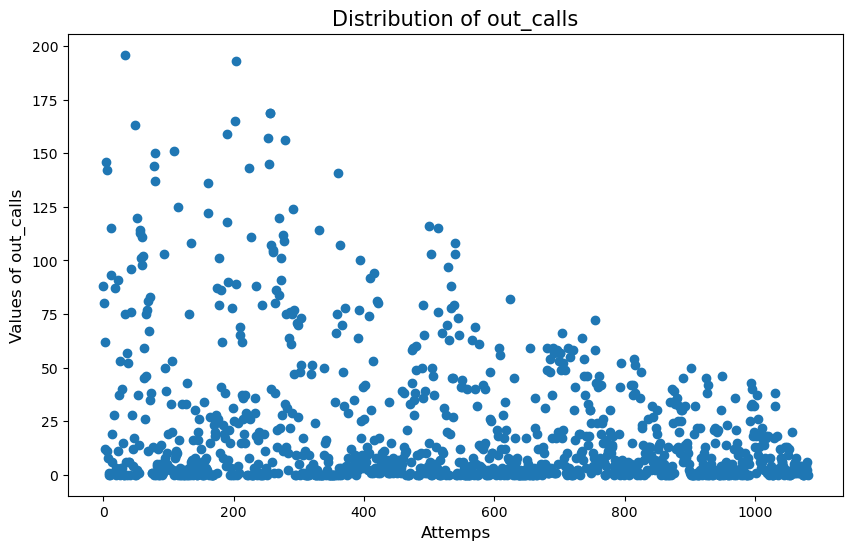

Lista de valores atípicos para out_calls - 90%, 92%, 95%, 97% ,99%
[ 65.    75.52  91.95 111.   146.76]


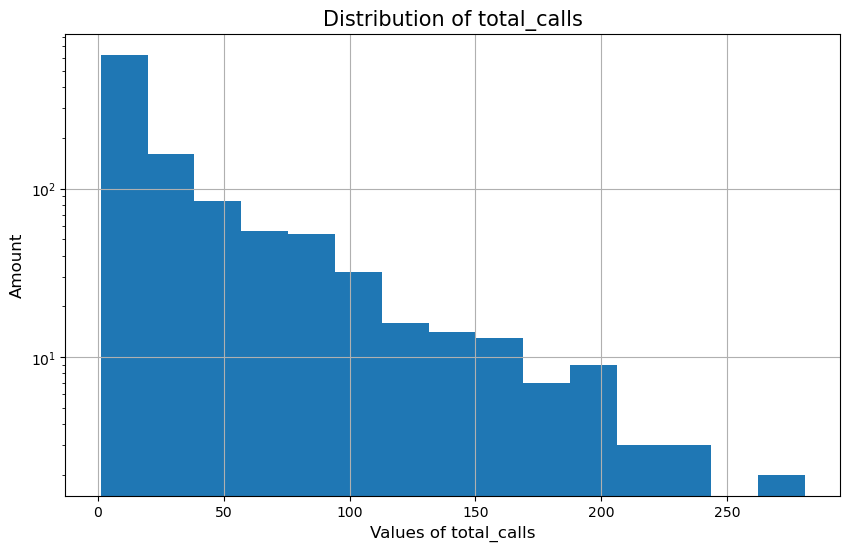

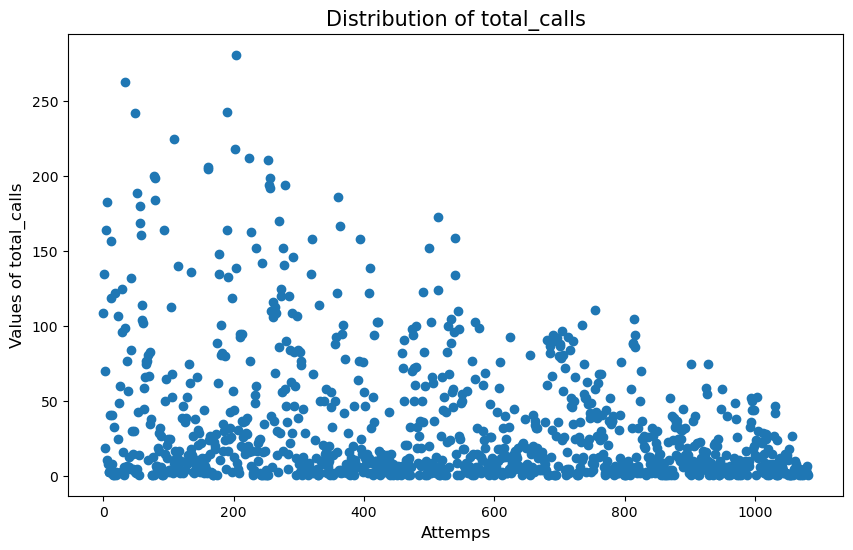

Lista de valores atípicos para total_calls - 90%, 92%, 95%, 97% ,99%
[ 91.   100.52 122.95 157.57 199.19]


In [236]:
plot_distribution(oper_dir.query('operator_id != 1').drop('operator_id', axis=1))

Podemos identificar que no todos los operadores reciben y hacen llamadas. Lo cual nos indica que debemos dividir a los operadores en dos grupos: receptores y emisores. No sería correcto medir a los operadores que sólo reciben llamadas entrantes por el número de llamadas salientes, por ejemplo.

**Distribución de operadores que reciben llamadas**

In [237]:

# Describir distribución de operadores por tipo de trabajo
oper_dir = telecom_df.query('direction == "in"').pivot_table(index='operator_id', columns='direction', values='calls_count', aggfunc='count'
                           ).reset_index().fillna(0)
oper_dir.columns = ['operator_id','in_calls']
oper_dir.sort_values(by='in_calls')

,operator_id,in_calls
750,973286.0,1
260,909896.0,1
270,911104.0,1
275,911152.0,1
680,954318.0,1
...,...,...
252,908958.0,88
155,901884.0,88
23,885890.0,93
253,908960.0,107


In [238]:
oper_dir.query('operator_id != 1').drop('operator_id', axis=1).describe()

,in_calls
count,750.000000
mean,15.552000
std,17.755778
min,1.000000
25%,2.250000
50%,8.500000
75%,23.000000
max,107.000000


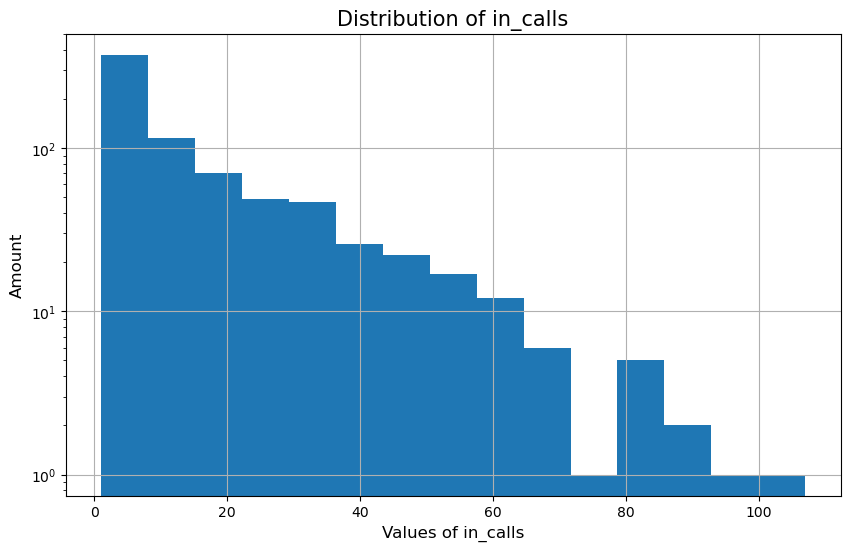

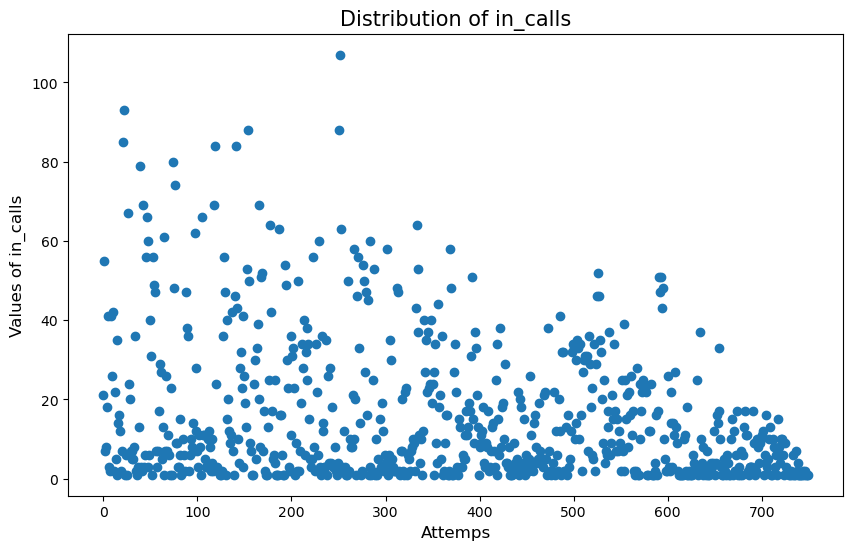

Lista de valores atípicos para in_calls - 90%, 92%, 95%, 97% ,99%
[41.   47.   53.   60.   79.51]


In [239]:
plot_distribution(oper_dir.query('operator_id != 1').drop('operator_id', axis=1))

**Distribución de operadores que hacen llamadas**

In [240]:

# Distribución de operadores por tipo de trabajo
oper_dir = telecom_df.query('direction == "out"').pivot_table(index='operator_id', columns='direction', values='calls_count', aggfunc='count'
                           ).reset_index().fillna(0)
oper_dir.columns = ['operator_id','out_calls']
oper_dir.sort_values(by='out_calls')

,operator_id,out_calls
829,961064.0,1
491,932246.0,1
75,891918.0,1
292,914272.0,1
852,969262.0,1
...,...,...
0,1.0,167
203,905564.0,169
204,905566.0,169
164,901884.0,193


In [241]:

oper_dir.query('operator_id != 1').drop('operator_id', axis=1).describe()

,out_calls
count,874.000000
mean,26.664760
std,33.833748
min,1.000000
25%,4.000000
50%,12.500000
75%,37.000000
max,196.000000


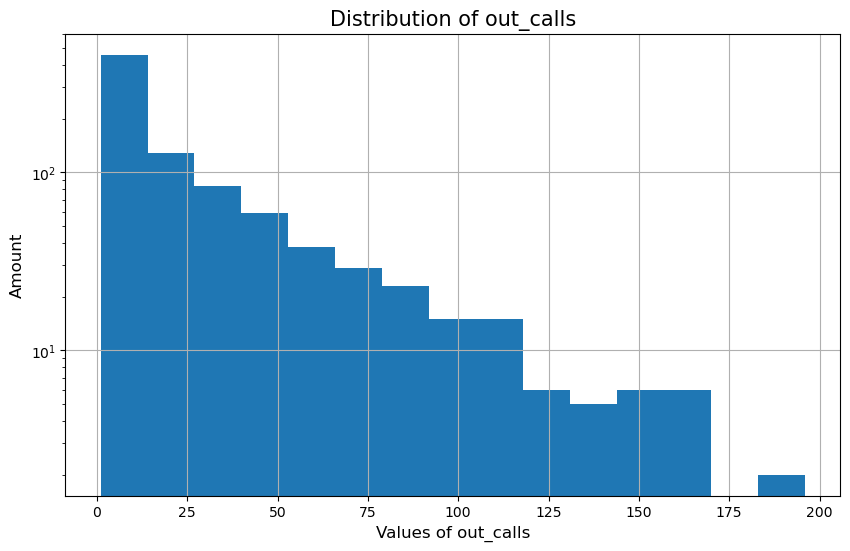

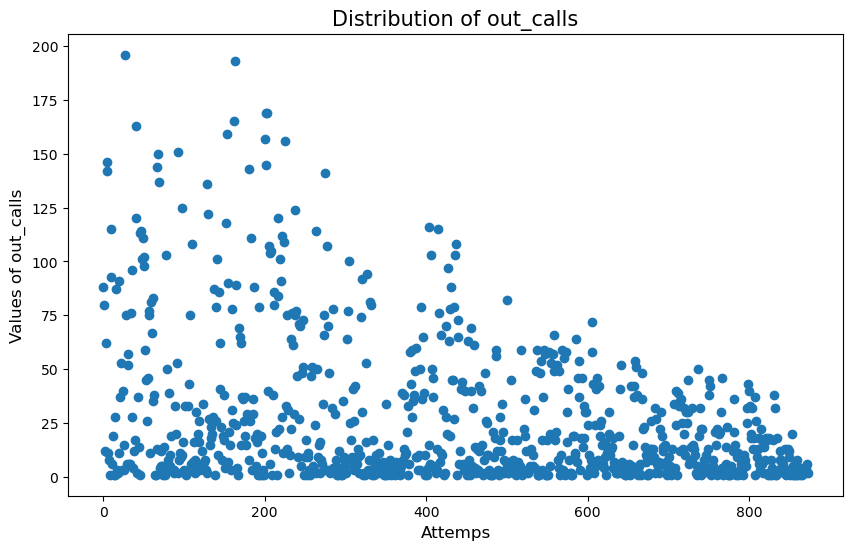

Lista de valores atípicos para out_calls - 90%, 92%, 95%, 97% ,99%
[ 75.    81.   102.35 115.   152.35]


In [242]:
plot_distribution(oper_dir.query('operator_id != 1').drop('operator_id', axis=1))

In [243]:

#Número de operadores que reciben y hacen llamadas
len(telecom_df.groupby('operator_id').agg({'direction': 'nunique'}).query('direction == 2'))

543

In [244]:
telecom_df.groupby('operator_id').agg({'direction': 'nunique'}).query('direction == 2').reset_index().head()


,operator_id,direction
0,1.0,2
1,879896.0,2
2,879898.0,2
3,880020.0,2
4,880022.0,2



De los 1082 operadores 750 reciben llamadas, 874 hacen llamadas y 543 hacen ambas cosas (sin incluir valores ausentes)

### Comprobar las correlaciones entre las columnas.

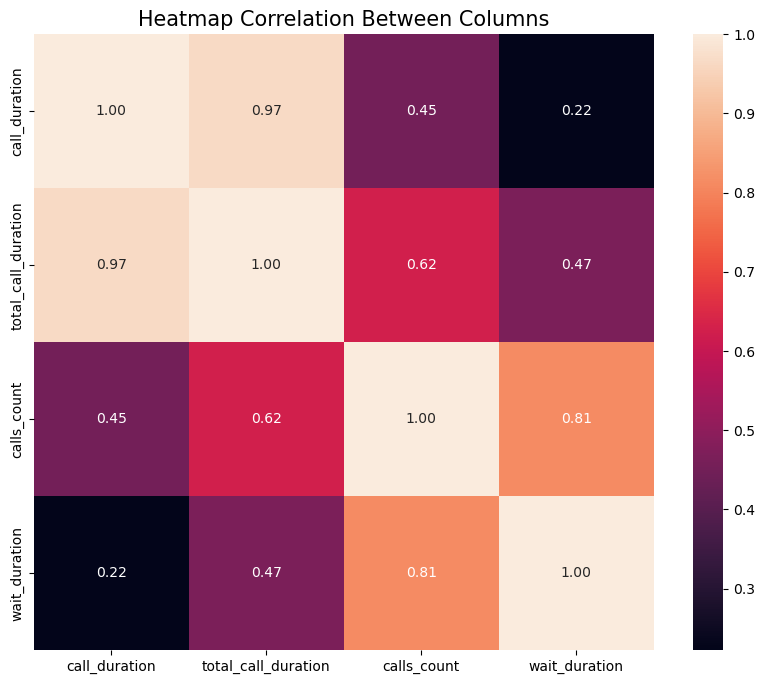

In [245]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(telecom_df[['call_duration','total_call_duration', 'calls_count', 'wait_duration']].corr(), annot=True, fmt='.2f', ax=ax)
plt.title('Heatmap Correlation Between Columns', fontsize=15)
plt.show()


De este gráfico podemos observar lo siguiente:

* Existe una fuerte correlación entre la duración de la llamada y la duración total de la llamada (97%), lo cual es evidente.

* Hay una correlación importante entre el conteo de llamadas y la duración de la espera (81%). Esto podría indicar que los operadores ineficaces tienen un gran número de llamadas perdidas y largos tiempos de espera, lo cual se va a comprobar más adelante.

**Agregar columnas para el número de llamadas exitosas y perdidas**

In [246]:

telecom_df['missed_calls'] = telecom_df['calls_count']
telecom_df.loc[telecom_df['is_missed_call']  == False, 'missed_calls'] -=  1
telecom_df['succ_calls'] = 0
telecom_df.loc[telecom_df['is_missed_call']  == False, 'succ_calls'] =  1
telecom_df = telecom_df[['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'missed_calls', 'succ_calls', 'call_duration', 'total_call_duration',
       'wait_duration', 'tariff_plan', 'date_start']]

In [247]:
telecom_df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,missed_calls,succ_calls,call_duration,total_call_duration,wait_duration,tariff_plan,date_start
0,166377,NaT,in,False,1.0,True,2,2,0,0,4,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,3,0,0,5,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,1,0,0,1,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,0,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,3,0,0,25,25,B,2019-08-01


### Definir operadores eficaces e ineficaces

Durante el análisis exploratorio de datos (EDA), observamos que no todos los operadores realizan y reciben llamadas (in & out). Lo cual significa que debemos analizar estos dos tipos de operadores por separado.

Se clasificará a los operadores que realizan llamadas (out) en función de:

* Número de llamadas exitosas (llamadas no perdidas, conversación en curso): se mide por cantidad.
* Porcentaje de llamadas hechas exitosas (llamadas no perdidas, conversación en curso): se mide por calidad.
* Tiempo de llamada: distancia de la media, la normalidad es el punto de refrencia; ni demasiado largo ni demasiado corto.

Se clasificará a los operadores que reciben llamadas (in) en función de:

* Número de llamadas entrantes exitosas (llamadas no perdidas, conversación en curso): se mide por cantidad.
* Porcentaje de llamadas entrantes perdidas: se mide por calidad. 
* Tiempo de espera en la llamada: cuanto menos, mejor.

**Definir a los operadores que realizan llamadas (out)**

In [248]:
out_df = telecom_df.query('direction == "out"')

In [249]:

# Calcular el número de llamadas exitosas y el porcentaje de éxito
out_calls = out_df.groupby('operator_id').agg({'calls_count': 'sum','succ_calls': 'sum'}).reset_index()
out_calls['succ_perc'] = round(out_calls.succ_calls / out_calls.calls_count * 100, 2)
out_calls.head()

,operator_id,calls_count,succ_calls,succ_perc
0,1.0,243,26,10.70
1,879896.0,475,41,8.63
2,879898.0,1265,20,1.58
3,880020.0,36,6,16.67
4,880022.0,189,33,17.46


In [250]:

# Calcular el tiempo de llamada promedio
out_call_avg= out_df.query('is_missed_call == False').groupby('operator_id').agg({
    'call_duration':  'mean'}).reset_index().rename(columns={'call_duration': 'avg_call_duration'})

# Calcular la distancia absoluta del promedio
out_call_avg['abs_dist_mean'] = abs(
out_call_avg['avg_call_duration'] - out_call_avg['avg_call_duration'].mean())
out_call_avg.head()

,operator_id,avg_call_duration,abs_dist_mean
0,1.0,707.384615,173.947610
1,879896.0,460.902439,72.534567
2,879898.0,727.850000,194.412994
3,880020.0,323.833333,209.603672
4,880022.0,443.484848,89.952157


In [251]:
out_call_avg[['avg_call_duration']].describe()

,avg_call_duration
count,774.000000
mean,533.437006
std,482.984234
min,4.000000
25%,144.625000
50%,388.465116
75%,785.848485
max,2344.000000


In [252]:
print("Número de operadores que no tuvieron éxito al realizar una llamada:" , len(out_calls) - len(out_call_avg))

Número de operadores que no tuvieron éxito al realizar una llamada: 101


Se puede observar que hay 101 operadores que no tuvieron éxito en hacer una llamada, su rango es probablemente el más bajo, por lo que se le dará el mayor valor de distancia absoluta desde la media.

In [253]:

# Mezclar la información de calls & time
out_data_grouped  = out_calls.merge(out_call_avg,  on='operator_id', how='left')

# Señal para llamadas fallidas = valor de 10,000
out_data_grouped.loc[out_data_grouped['avg_call_duration'].isnull(), 'avg_call_duration'] = 10000
out_data_grouped.loc[out_data_grouped['abs_dist_mean'].isnull(), 'abs_dist_mean'] = 10000

# Redondear resultados del tiempo
out_data_grouped['avg_call_duration'] = round(out_data_grouped['avg_call_duration'] , 2)
out_data_grouped['abs_dist_mean'] = round(out_data_grouped['abs_dist_mean'] , 2)
out_data_grouped.head()

,operator_id,calls_count,succ_calls,succ_perc,avg_call_duration,abs_dist_mean
0,1.0,243,26,10.70,707.38,173.95
1,879896.0,475,41,8.63,460.90,72.53
2,879898.0,1265,20,1.58,727.85,194.41
3,880020.0,36,6,16.67,323.83,209.60
4,880022.0,189,33,17.46,443.48,89.95


**Clasificar resultados**

* succ_calls - cuanto más, mejor
* succ_perc - cuanto más alto, mejor
* abs_dist_mean - cuanto menos, mejor

In [254]:

def oper_rank(total_rank):
    # Obtiene el rango (número)
# Devuelve el número del grupo al que pertenece el rango.
# 3-5: Ineficaz
# 6-9: Regular
# 10-12: Eficaz
    if total_rank < 6:
        return 1
    elif total_rank < 10:
        return 2
    return 3

In [255]:
# Establecer valores predeterminados para los grupos
Q = 4
range_asc = range(1, Q +  1)
range_desc= range(Q, 0, -1)

# Clasificar número de llamadas exitosas
out_data_grouped = out_data_grouped.sort_values(by='succ_calls')
out_data_grouped['succ_calls_rank'] = pd.qcut(out_data_grouped['succ_calls'], Q , labels=range_asc).astype('int')

# Clasificar porcentaje de llamadas exitosas
out_data_grouped = out_data_grouped.sort_values(by='succ_perc')
out_data_grouped['succ_perc_rank'] = pd.qcut(out_data_grouped['succ_perc'], Q , labels=range_asc).astype('int')

# Clasificar tiempo de llamada promedio
out_data_grouped = out_data_grouped.sort_values(by='abs_dist_mean')
out_data_grouped['call_duration_rank'] = pd.qcut(out_data_grouped['abs_dist_mean'], Q , labels=range_desc).astype('int')

out_data_grouped['total_rank'] = out_data_grouped.succ_calls_rank + out_data_grouped.succ_perc_rank + out_data_grouped.call_duration_rank


out_data_grouped['rank_group'] = out_data_grouped['total_rank'].apply(oper_rank)

out_data_grouped = out_data_grouped.sort_values(by=['total_rank', 'rank_group'])
out_data_grouped

,operator_id,calls_count,succ_calls,succ_perc,avg_call_duration,abs_dist_mean,succ_calls_rank,succ_perc_rank,call_duration_rank,total_rank,rank_group
763,952466.0,42,1,2.38,1098.00,564.56,1,1,1,3,1
680,945284.0,335,1,0.30,1148.00,614.56,1,1,1,3,1
694,945318.0,332,1,0.30,1281.00,747.56,1,1,1,3,1
771,953458.0,38,1,2.63,1327.00,793.56,1,1,1,3,1
367,919482.0,76,1,1.32,1449.00,915.56,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
230,906416.0,77,22,28.57,604.14,70.70,4,4,4,12,3
467,929876.0,78,24,30.77,428.71,104.73,4,4,4,12,3
322,917856.0,74,21,28.38,428.43,105.01,4,4,4,12,3
239,907224.0,299,81,27.09,342.40,191.04,4,4,4,12,3


**Definir operadores que reciben llamadas**

In [256]:
in_calls = telecom_df.query('direction == "in"')

In [257]:

# Calcular número y porcentaje de llamadas perdidas
in_data_calls = in_calls.groupby('operator_id').agg({'calls_count': 'sum','succ_calls': 'sum', 
                                                    'missed_calls': 'sum'}).reset_index()
in_data_calls['miss_perc'] = round(in_data_calls.missed_calls / in_data_calls.calls_count * 100, 2)
in_data_calls.head()

,operator_id,calls_count,succ_calls,missed_calls,miss_perc
0,1.0,32263,42,32221,99.87
1,879896.0,58,21,37,63.79
2,879898.0,102,55,47,46.08
3,880020.0,7,7,0,0.00
4,880022.0,8,8,0,0.00


In [258]:
# Calcular el promedio del tiempo en espera 
in_avg_time_call = in_calls.query('is_missed_call == False').groupby('operator_id').agg({
    'wait_duration':  'mean'}).reset_index().rename(columns={'wait_duration': 'avg_wait_duration'})

in_avg_time_call.head()

,operator_id,avg_wait_duration
0,1.0,22.690476
1,879896.0,27.333333
2,879898.0,30.200000
3,880020.0,7.714286
4,880022.0,14.000000


In [259]:
in_avg_time_call[['avg_wait_duration']].describe()

,avg_wait_duration
count,749.000000
mean,49.651771
std,66.774095
min,1.000000
25%,17.370370
50%,30.888889
75%,56.300000
max,753.100000


In [260]:
print("Número de operadores que no tuvieron éxito al realizar una llamada:" , len(in_data_calls) - len(in_avg_time_call))

Número de operadores que no tuvieron éxito al realizar una llamada: 2


Podemos observar que sólo hay 2 operadores que no pudieron realizar una llamada. Su rango podría ser el más bajo, por lo que se le dará el mayor valor de duración de espera.

In [261]:
# Mezclar información de calls & time
in_data_grouped  = in_data_calls.merge(in_avg_time_call,  on='operator_id', how='left')

# Señal de llamadas fallidas = valor de 1000
in_data_grouped.loc[in_data_grouped['avg_wait_duration'].isnull(), 'avg_wait_duration'] = 1000

# Duración promedio de espera 
in_data_grouped['avg_wait_duration'] = round(in_data_grouped['avg_wait_duration'] , 2)

in_data_grouped.head()


,operator_id,calls_count,succ_calls,missed_calls,miss_perc,avg_wait_duration
0,1.0,32263,42,32221,99.87,22.69
1,879896.0,58,21,37,63.79,27.33
2,879898.0,102,55,47,46.08,30.20
3,880020.0,7,7,0,0.00,7.71
4,880022.0,8,8,0,0.00,14.00


**Clasificar resultados**

* succ_calls - cuanto más, mejor
* miss_perc - cuanto más bajo, mejor
* avg_wait_duration - cuanto menos, mejor

In [262]:
# Establecer valores predeterminados para los grupos
Q = 4
RANGE_ASC = range(1, Q +  1)
RANGE_DESC = range(Q, 0, -1)

# Clasificar número de llamadas exitosas
in_data_grouped = in_data_grouped.sort_values(by='succ_calls')
in_data_grouped['succ_calls_rank'] = pd.qcut(in_data_grouped['succ_calls'], Q , labels=RANGE_ASC).astype('int')

# Clasificar porcentaje de llamadas exitosas
in_data_grouped = in_data_grouped.sort_values(by='miss_perc')
in_data_grouped['miss_perc_rank'] = pd.qcut(in_data_grouped['miss_perc'], Q , labels=RANGE_DESC).astype('int')

# Clasificar tiempo promedio de llamada
in_data_grouped = in_data_grouped.sort_values(by='avg_wait_duration')
in_data_grouped['avg_wait_duration_rank'] = pd.qcut(in_data_grouped['avg_wait_duration'], Q , labels=RANGE_DESC).astype('int')

in_data_grouped['total_rank'] = in_data_grouped.succ_calls_rank + in_data_grouped.miss_perc_rank + in_data_grouped.avg_wait_duration_rank

in_data_grouped['rank_group'] = in_data_grouped['total_rank'].apply(oper_rank)

in_data_grouped = in_data_grouped.sort_values(by=['total_rank', 'rank_group'])
in_data_grouped

,operator_id,calls_count,succ_calls,missed_calls,miss_perc,avg_wait_duration,succ_calls_rank,miss_perc_rank,avg_wait_duration_rank,total_rank,rank_group
678,954086.0,31,1,30,96.77,64.00,1,1,1,3,1
173,903974.0,10,2,8,80.00,83.50,1,1,1,3,1
118,898920.0,13,2,11,84.62,97.00,1,1,1,3,1
111,898414.0,24,2,22,91.67,126.00,1,1,1,3,1
12,882688.0,15,2,13,86.67,336.50,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
99,896014.0,14,12,2,14.29,15.75,3,4,4,11,3
86,895170.0,11,10,1,9.09,16.10,3,4,4,11,3
132,900492.0,17,14,3,17.65,16.29,3,4,4,11,3
374,923944.0,40,27,13,32.50,17.37,4,3,4,11,3


## Comprobar hipótesis estadísticas

* Operadores eficaces: grupo 3

* Operadores promedio: grupo 2

* Operadores ineficaces: grupo 1

In [263]:

in_data_grouped.query('operator_id  == 1')

,operator_id,calls_count,succ_calls,missed_calls,miss_perc,avg_wait_duration,succ_calls_rank,miss_perc_rank,avg_wait_duration_rank,total_rank,rank_group
0,1.0,32263,42,32221,99.87,22.69,4,1,3,8,2


Podemos ver que los operadores vacíos están en el grupo promedio (rango 2), pero sus valores son atípicos. Así que, lo mejor antes de usar estadísticas es descartarlos para evitar confusiones.

In [264]:

out_data_grouped.query('operator_id  == 1')

,operator_id,calls_count,succ_calls,succ_perc,avg_call_duration,abs_dist_mean,succ_calls_rank,succ_perc_rank,call_duration_rank,total_rank,rank_group
0,1.0,243,26,10.7,707.38,173.95,4,2,4,10,3


Podemos ver que los operadores vacíos están en el grupo efectivo y sus valores son normales y no atípicos. Así que, podemos mantenerlos.

In [265]:

# Definir operadores efectivos e ineficaces que reciben llamadas.
in_effective = in_data_grouped.query('rank_group == 3')
in_average = in_data_grouped.query('rank_group == 2')
in_ineffective = in_data_grouped.query('rank_group == 1')

# Definir operadores efectivos e ineficaces que hacen llamadas.
out_effective = out_data_grouped.query('rank_group == 3')
out_average = out_data_grouped.query('rank_group == 2')
out_ineffective = out_data_grouped.query('rank_group == 1')

**Diferencia entre el tiempo promedio de espera de llamadas entrantes de operadores eficaces e ineficaces.**

In [266]:
# Distribución de tiempo de espera para los operadores eficaces
in_effective[['avg_wait_duration']].describe()

,avg_wait_duration
count,77.000000
mean,15.103896
std,6.385548
min,2.500000
25%,11.000000
50%,14.360000
75%,17.250000
max,30.860000


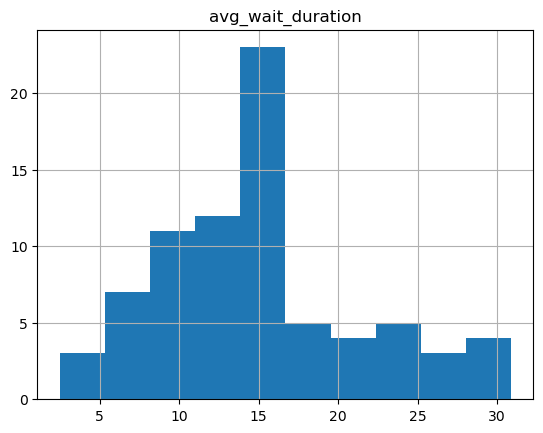

In [267]:
in_effective[['avg_wait_duration']].hist()
plt.show()

In [268]:
# Distribución de tiempo de espera de los operadores ineficaces, sin los valores ausentes que se marcaron con 1000.
in_ineffective.query('avg_wait_duration != 1000')[['avg_wait_duration']].describe()

,avg_wait_duration
count,96.000000
mean,106.626250
std,109.316201
min,20.000000
25%,54.000000
50%,78.310000
75%,108.572500
max,753.100000


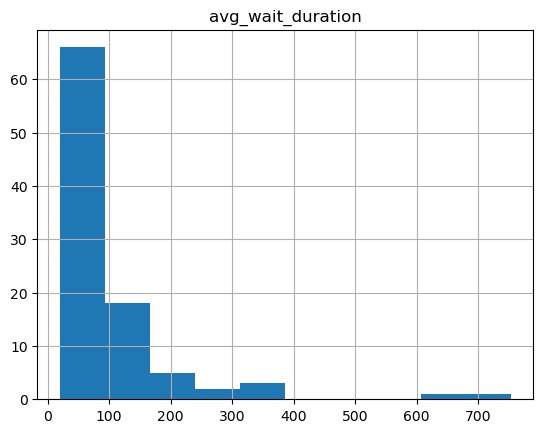

In [269]:
in_ineffective.query('avg_wait_duration != 1000')[['avg_wait_duration']].hist()
plt.show()

Podemos observar que los datos no se distribuyen normalmente, por lo que utilizaremos la prueba de Mann-Whitney.

In [270]:
# Muestras
effective_wait = in_effective['avg_wait_duration']
ineffective_wait = in_ineffective.query('avg_wait_duration != 1000')['avg_wait_duration']

# General stats
print('Tiempo de espera para los operadores eficaces - Operadores: {} | Espera promedio: {:.2f} | Std: {:.2f} \n'.format(
                                                                       effective_wait.count(),
                                                                       effective_wait.mean(),
                                                                       effective_wait.std()))

print('Tiempo de espera para los operadores ineficaces - Operadores: {} | Espera promedio: {:.2f} | Std: {:.2f} \n'.format(
                                                                       ineffective_wait.count(),
                                                                       ineffective_wait.mean(),
                                                                       ineffective_wait.std()))

alpha = 0.05
p_value = st.mannwhitneyu(effective_wait, ineffective_wait)[1]

print('P value is: {0:.5f} \n'.format(p_value))
if p_value < alpha:
    print('Hipótesis nula rechazada: Existe una diferencia significativa entre los tiempos de espera de los operadores.')
else:
    print('No se pudo rechazar la hipótesis nula: No podemos afirmar que exista una diferencia significativa entre los operadores')

Tiempo de espera para los operadores eficaces - Operadores: 77 | Espera promedio: 15.10 | Std: 6.39 

Tiempo de espera para los operadores ineficaces - Operadores: 96 | Espera promedio: 106.63 | Std: 109.32 

P value is: 0.00000 

Hipótesis nula rechazada: Existe una diferencia significativa entre los tiempos de espera de los operadores.


**Diferencia entre las proporciones de llamadas entrantes perdidas de operadores eficaces e ineficaces**

In [271]:
in_data_grouped

,operator_id,calls_count,succ_calls,missed_calls,miss_perc,avg_wait_duration,succ_calls_rank,miss_perc_rank,avg_wait_duration_rank,total_rank,rank_group
678,954086.0,31,1,30,96.77,64.00,1,1,1,3,1
173,903974.0,10,2,8,80.00,83.50,1,1,1,3,1
118,898920.0,13,2,11,84.62,97.00,1,1,1,3,1
111,898414.0,24,2,22,91.67,126.00,1,1,1,3,1
12,882688.0,15,2,13,86.67,336.50,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
99,896014.0,14,12,2,14.29,15.75,3,4,4,11,3
86,895170.0,11,10,1,9.09,16.10,3,4,4,11,3
132,900492.0,17,14,3,17.65,16.29,3,4,4,11,3
374,923944.0,40,27,13,32.50,17.37,4,3,4,11,3


In [272]:
# grupo 1 = ineficaz
# group 3 = eficaz

# Número de llamadas perdidas por grupo
sucesses1 = in_data_grouped.query('rank_group == 1').missed_calls.sum()
sucesses3 = in_data_grouped.query('rank_group == 3').missed_calls.sum()
sucessesCombined = sucesses1 + sucesses3
    
# Número de llamadas totales por grupo
trials1 = in_data_grouped.query('rank_group == 1').calls_count.sum()
trials3 = in_data_grouped.query('rank_group == 3').calls_count.sum()
trialsCombined = trials1 + trials3
    
# Porcentaje de llamadas entrantes perdidas por grupo
p1 = sucesses1 / trials1
p3 = sucesses3 / trials3
pCombined = sucessesCombined / trialsCombined
    
difference = p1 - p3 
distr = st.norm(0, 1)
    
z_value = difference / math.sqrt(pCombined * (1 - pCombined) * (1/trials1 + 1/trials3))
p_value = (1 - distr.cdf(abs(z_value))) * 2
alpha =  0.05
    
print('Grupo eficaz: Número de operadores: {} | llamadas perdidas: {} | total de llamadas: {}  | Proporción: {:.3%} \n'.format(
        len(in_data_grouped.query('rank_group == 3')),
        sucesses3, 
        trials3,
        p3))

print('Grupo ineficaz: Número de operadores: {} | llamadas perdidas: {} | total de llamadas: {}  | Proportion: {:.3%} \n'.format(
        len(in_data_grouped.query('rank_group == 1')),
        sucesses1, 
        trials1,
        p1))

print('H0: No hay diferencia significativa entre las proporciones de los grupos.\n')
print('H1: Hay una diferencia significativa entre las proporciones de los grupos.\n')
print('Alpha level: {} \n'.format(alpha))
print('RESULTS: p-value: {:.5f} \n'.format(p_value))
if (p_value < alpha):
    print("Rechazo de la hipótesis nula: existe una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para considerar las proporciones diferentes")

Grupo eficaz: Número de operadores: 77 | llamadas perdidas: 671 | total de llamadas: 1851  | Proporción: 36.251% 

Grupo ineficaz: Número de operadores: 98 | llamadas perdidas: 5190 | total de llamadas: 5850  | Proportion: 88.718% 

H0: No hay diferencia significativa entre las proporciones de los grupos.

H1: Hay una diferencia significativa entre las proporciones de los grupos.

Alpha level: 0.05 

RESULTS: p-value: 0.00000 

Rechazo de la hipótesis nula: existe una diferencia significativa entre las proporciones


**Diferencia entre el número promedio de llamadas salientes de operadores eficaces e ineficaces.**

In [273]:
out_data_grouped

,operator_id,calls_count,succ_calls,succ_perc,avg_call_duration,abs_dist_mean,succ_calls_rank,succ_perc_rank,call_duration_rank,total_rank,rank_group
763,952466.0,42,1,2.38,1098.00,564.56,1,1,1,3,1
680,945284.0,335,1,0.30,1148.00,614.56,1,1,1,3,1
694,945318.0,332,1,0.30,1281.00,747.56,1,1,1,3,1
771,953458.0,38,1,2.63,1327.00,793.56,1,1,1,3,1
367,919482.0,76,1,1.32,1449.00,915.56,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
230,906416.0,77,22,28.57,604.14,70.70,4,4,4,12,3
467,929876.0,78,24,30.77,428.71,104.73,4,4,4,12,3
322,917856.0,74,21,28.38,428.43,105.01,4,4,4,12,3
239,907224.0,299,81,27.09,342.40,191.04,4,4,4,12,3


In [274]:
# Distribución de llamadas de operadores eficaces
out_effective[['calls_count']].describe()

,calls_count
count,213.000000
mean,229.159624
std,265.000379
min,5.000000
25%,62.000000
50%,157.000000
75%,271.000000
max,1742.000000


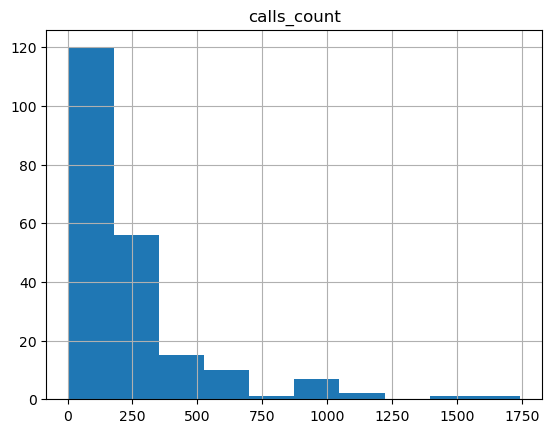

In [275]:
out_effective[['calls_count']].hist()
plt.show()

In [276]:
#Distribución de llamadas de operadores ineficaces
out_ineffective[['calls_count']].describe()

,calls_count
count,200.000000
mean,108.845000
std,171.235008
min,1.000000
25%,2.000000
50%,30.500000
75%,134.500000
max,984.000000


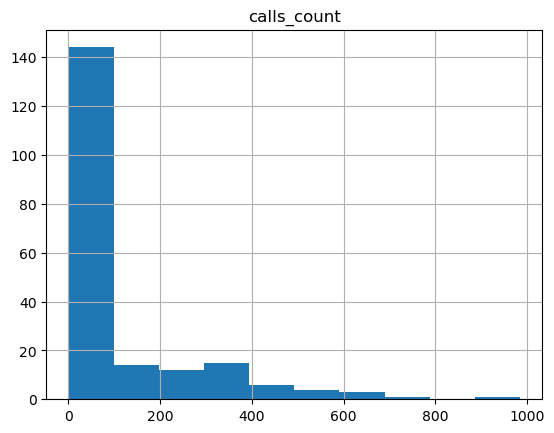

In [277]:
out_ineffective[['calls_count']].hist()
plt.show()

Podemos observar que los datos no se distribuyen normalmente, por lo que utilizaremos la prueba de Mann-Whitney.

In [278]:
# Muestras
effective_calls = out_effective['calls_count']
ineffective_calls = out_ineffective['calls_count']

# Estadísticas generales
print('Effective operators - Number of operators: {} | Average number of calls: {:.2f} | Std: {:.2f} \n'.format(
                                                                       effective_calls.count(),
                                                                       effective_calls.mean(),
                                                                       effective_calls.std()))

print('Ineffective operators - Number of operators: {} | Average number of calls: {:.2f} | Std: {:.2f} \n'.format(
                                                                       ineffective_calls.count(),
                                                                       ineffective_calls.mean(),
                                                                       ineffective_calls.std()))

alpha = 0.05
p_value = st.mannwhitneyu(effective_calls, ineffective_calls)[1]

print('P value is: {0:.5f} \n'.format(p_value))
if p_value < alpha:
    
    print('Hipótesis nula rechazada: Existe una diferencia significativa entre el número de llamadas de los operadores')
else:
    print('No se pudo rechazar la hipótesis nula: ¡No podemos afirmar que exista una diferencia significativa entre los operadores')

Effective operators - Number of operators: 213 | Average number of calls: 229.16 | Std: 265.00 

Ineffective operators - Number of operators: 200 | Average number of calls: 108.84 | Std: 171.24 

P value is: 0.00000 

Hipótesis nula rechazada: Existe una diferencia significativa entre el número de llamadas de los operadores


Existe una diferencia significativa entre los operadores eficaces e ineficaces

**Preparar información para ser analizada en Tableau**

In [279]:

# Unificar columnas
out_data_grouped['direction'] = 'out'
out_data_grouped['missed_calls'] = out_data_grouped['calls_count'] - out_data_grouped['succ_calls']
out_data_grouped['miss_perc'] = round(out_data_grouped['missed_calls'] / out_data_grouped['calls_count'] * 100 , 2)
out_data_grouped['avg_wait_duration'] = -1

# Definir operadores 'out'
out_tabl = out_data_grouped[['operator_id', 'direction', 'calls_count', 'succ_calls', 'missed_calls',  'succ_perc', 'miss_perc', 
             'avg_wait_duration', 'rank_group']]
out_tabl.head()

,operator_id,direction,calls_count,succ_calls,missed_calls,succ_perc,miss_perc,avg_wait_duration,rank_group
763,952466.0,out,42,1,41,2.38,97.62,-1,1
680,945284.0,out,335,1,334,0.30,99.70,-1,1
694,945318.0,out,332,1,331,0.30,99.70,-1,1
771,953458.0,out,38,1,37,2.63,97.37,-1,1
367,919482.0,out,76,1,75,1.32,98.68,-1,1


In [280]:
# Unificar columnas
in_data_grouped['direction'] = 'in'
in_data_grouped['succ_perc'] = round(in_data_grouped['succ_calls'] / in_data_grouped['calls_count'] * 100 , 2)

# Definir operadores 'in' 
in_tabl = in_data_grouped[['operator_id', 'direction', 'calls_count', 'succ_calls', 'missed_calls',
       'succ_perc', 'miss_perc', 'avg_wait_duration', 'rank_group']]
in_tabl.head()

,operator_id,direction,calls_count,succ_calls,missed_calls,succ_perc,miss_perc,avg_wait_duration,rank_group
678,954086.0,in,31,1,30,3.23,96.77,64.0,1
173,903974.0,in,10,2,8,20.00,80.00,83.5,1
118,898920.0,in,13,2,11,15.38,84.62,97.0,1
111,898414.0,in,24,2,22,8.33,91.67,126.0,1
12,882688.0,in,15,2,13,13.33,86.67,336.5,1


In [281]:
# Agrupar la información 
tableau_info = pd.concat([in_tabl, out_tabl], axis=0)
tableau_info = tableau_info.merge(telecom_df[['operator_id', 'tariff_plan']].drop_duplicates(), on='operator_id', how='inner'
                       ).query('rank_group in (1, 2, 3)')
tableau_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1630 entries, 0 to 1629
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   operator_id        1630 non-null   float64 
 1   direction          1630 non-null   object  
 2   calls_count        1630 non-null   int64   
 3   succ_calls         1630 non-null   int64   
 4   missed_calls       1630 non-null   int64   
 5   succ_perc          1630 non-null   float64 
 6   miss_perc          1630 non-null   float64 
 7   avg_wait_duration  1630 non-null   float64 
 8   rank_group         1630 non-null   int64   
 9   tariff_plan        1630 non-null   category
dtypes: category(1), float64(4), int64(4), object(1)
memory usage: 129.1+ KB


In [282]:
tableau_info.head()


,operator_id,direction,calls_count,succ_calls,missed_calls,succ_perc,miss_perc,avg_wait_duration,rank_group,tariff_plan
0,954086.0,in,31,1,30,3.23,96.77,64.0,1,C
1,903974.0,in,10,2,8,20.00,80.00,83.5,1,C
2,898920.0,in,13,2,11,15.38,84.62,97.0,1,B
3,898414.0,in,24,2,22,8.33,91.67,126.0,1,B
4,882688.0,in,15,2,13,13.33,86.67,336.5,1,B


In [283]:
tableau_info.to_csv('telecom_tableu')

## Link a la presentación: https://drive.google.com/file/d/1o8CbD27dsoKDqYE1bVFjxztSGIi5qvff/view?usp=sharing
## Link a Tableau: https://public.tableau.com/views/Final_project_17425902572350/Outcallsaverage?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link